In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from nltk import FreqDist
from wordcloud import WordCloud
import re
from collections import defaultdict, Counter
import copy
from PIL import Image

In [2]:
# 以下代码从全局设置字体为Arial Unicode MS，解决显示中文问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams['axes.unicode_minus'] = False

## Q1

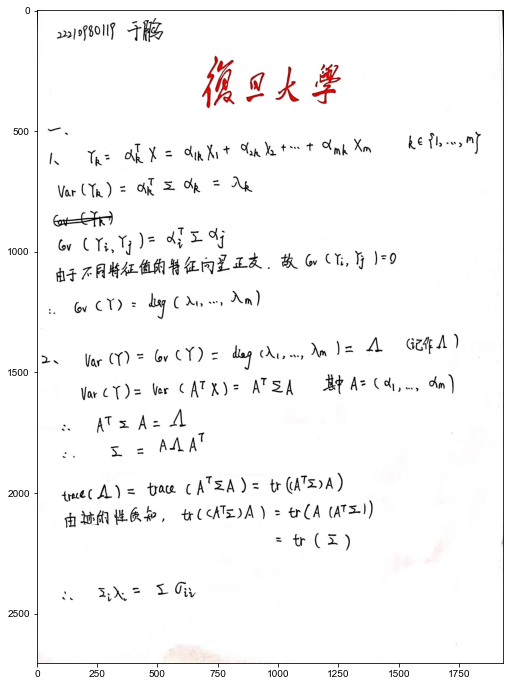

In [95]:
img = Image.open("01.jpeg")
fig = plt.figure(figsize=(20, 12))
plt.imshow(img)
plt.show()

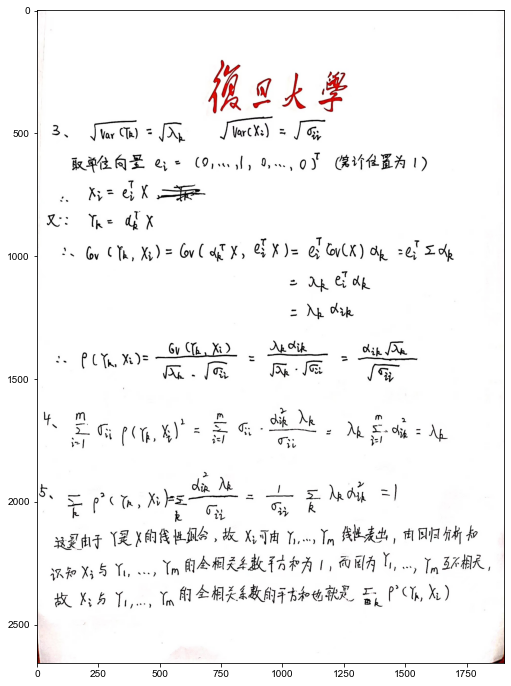

In [96]:
img = Image.open("02.jpeg")
fig = plt.figure(figsize=(20, 12))
plt.imshow(img)
plt.show()

## Q2

In [3]:
original_data = pd.read_csv('soccer.csv')

In [4]:
original_data.head()

,Unnamed: 0,球员,身价,射门,射正,进球,偷球,关键传球,带球摆脱,助攻,被侵犯,解围,拦截,封堵,头球,铲断
0,1,托马斯,180.0,32,9,5,15,8,5,1,13,11,5,5,47,15
1,2,M.加西亚,162.0,30,7,2,27,12,12,1,53,59,26,7,107,83
2,3,马丁阿古拉甘,135.0,1,0,0,10,8,25,0,28,56,26,11,20,42
3,4,伊利,540.0,2,1,0,0,2,0,0,2,25,8,7,24,7
4,5,迭戈.罗兰,315.0,10,2,0,15,5,12,0,17,8,4,0,9,13


In [5]:
original_data.shape

(1563, 16)

In [6]:
# 去掉存在NaN的行
data = original_data.dropna()

In [7]:
data.shape

(1563, 16)

In [15]:
X = data.drop(labels=['Unnamed: 0', '身价', '球员'], axis=1)
Y = data['身价']

In [16]:
X.head()

,射门,射正,进球,偷球,关键传球,带球摆脱,助攻,被侵犯,解围,拦截,封堵,头球,铲断
0,32,9,5,15,8,5,1,13,11,5,5,47,15
1,30,7,2,27,12,12,1,53,59,26,7,107,83
2,1,0,0,10,8,25,0,28,56,26,11,20,42
3,2,1,0,0,2,0,0,2,25,8,7,24,7
4,10,2,0,15,5,12,0,17,8,4,0,9,13


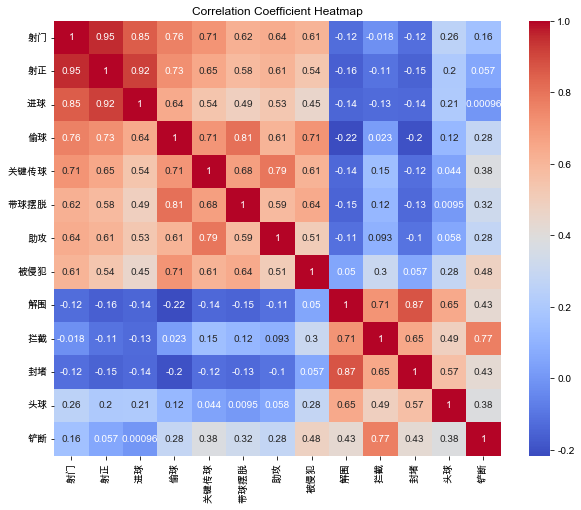

In [17]:
# 计算相关系数
corr_matrix = X.corr()

# 设置图形尺寸
plt.figure(figsize=(10, 8))

# 绘制热力图
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.show()

从结果来看，射门和射正、射门和进球、射正和进球都存在明显正相关关系，也比较符合实际情况，负责射门的球员一般技术较好，比较容易射正、进球；解围和射门、拦截和射门等存在负相关关系，猜测可能是负责解围、拦截等任务的球员主要起到辅助角色，不负责射门任务

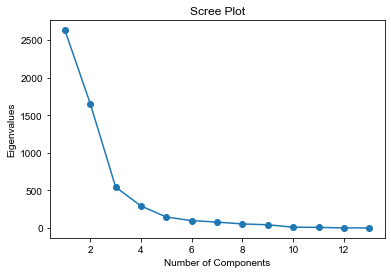

In [19]:
# 执行主成分分析
pca = PCA()
pca.fit(X)

# 计算特征值
eigenvalues = pca.explained_variance_

# 绘制崖底碎石图
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.show()

由图可见，拐点出现在$k=3$处，$k=3$之后的曲线就比较平缓了，所以取前2个主成分

In [22]:
# 执行主成分分析
pca = PCA(n_components=2)  # 设置主成分个数为2
pca.fit(X)

# 计算每一位球员的主成分得分
player_scores = pca.transform(X)

# 创建包含主成分得分的DataFrame
player_scores_df = pd.DataFrame(player_scores, columns=['PC1', 'PC2'])

# 将得分与原始数据合并
result = pd.concat([X, player_scores_df], axis=1)

In [91]:
sqrt_lambda_k = np.tile(np.sqrt(pca.explained_variance_), (13, 1)).T  # (2, 13)
alpha_ik = pca.components_  # (2, 13)
sqrt_sigma_ii = np.tile(np.sqrt(X.var().values), (2, 1))  # (2, 13)

# element-wise计算相关系数也即因子负荷量
rou_Yk_Xi = alpha_ik * sqrt_lambda_k / sqrt_sigma_ii  # (2, 13)

In [94]:
loadings_df = pd.DataFrame(rou_Yk_Xi.T, columns=['PC1', 'PC2'], index=X.columns)
loadings_df

,PC1,PC2
射门,0.033603,0.899396
射正,-0.030039,0.842679
进球,-0.027091,0.736649
偷球,-0.049914,0.913418
关键传球,-0.000006,0.835926
带球摆脱,-0.028825,0.810738
助攻,-0.001877,0.713582
被侵犯,0.227417,0.789502
解围,0.950508,-0.206666
拦截,0.791603,0.085965


从结果来看：
* 解围、封堵、头球与PC1有极强的正相关性，拦截与PC1有很强的正相关性，铲断与PC1中等程度正相关
* 射门、射正、偷球、关键传球等变量与PC2有极强的正相关性，进球、助攻、被侵犯等变量与PC2有很强的正相关性，解围与PC2有弱负相关性

In [28]:
result.head()

,射门,射正,进球,偷球,关键传球,带球摆脱,助攻,被侵犯,解围,拦截,封堵,头球,铲断,PC1,PC2
0,32,9,5,15,8,5,1,13,11,5,5,47,15,-18.309131,-1.096547
1,30,7,2,27,12,12,1,53,59,26,7,107,83,75.168517,33.924389
2,1,0,0,10,8,25,0,28,56,26,11,20,42,17.030229,-17.850396
3,2,1,0,0,2,0,0,2,25,8,7,24,7,-21.024189,-41.576513
4,10,2,0,15,5,12,0,17,8,4,0,9,13,-40.905736,-17.842456


对比0号和1号球员，1号球员的PC1得分明显大于0号的PC1得分，发现1号球员的头球数107、解围数59大幅度大于0号球员的头球数47、解围数11，1号球员的拦截、铲断数也都大于0号球员；1号球员的PC2得分明显大于0号的PC2得分，虽然两个人的射门数据差不多，但1号的偷球、被侵犯、带球摆脱大于0号，因此1号的PC2得分大了很多。以上分析结果吻合主成分的载荷情况。

根据肘部法则来判断需要几个中心，也就是改变$k$，计算不同$k$下的代价函数，找到拐点：

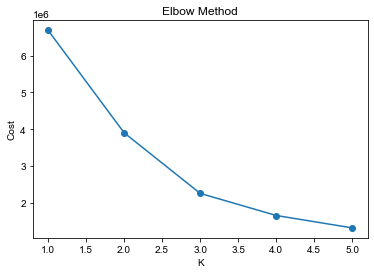

In [31]:
# 计算不同K值下的代价函数值
k_values = range(1, 6)
costs = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(player_scores)
    costs.append(kmeans.inertia_)

# 绘制K值与代价函数值的关系图
plt.plot(k_values, costs, marker='o')
plt.xlabel('K')
plt.ylabel('Cost')
plt.title('Elbow Method')
plt.show()

从结果来看，$k=3$时候是拐点，所以取3个类即可

In [42]:
k = 3  # 设置聚类簇数为3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(player_scores)

# 将聚类结果添加到数据中
result['cluster'] = kmeans.labels_

result.head(10)

,射门,射正,进球,偷球,关键传球,带球摆脱,助攻,被侵犯,解围,拦截,封堵,头球,铲断,PC1,PC2,cluster
0,32,9,5,15,8,5,1,13,11,5,5,47,15,-18.309131,-1.096547,0
1,30,7,2,27,12,12,1,53,59,26,7,107,83,75.168517,33.924389,1
2,1,0,0,10,8,25,0,28,56,26,11,20,42,17.030229,-17.850396,0
3,2,1,0,0,2,0,0,2,25,8,7,24,7,-21.024189,-41.576513,0
4,10,2,0,15,5,12,0,17,8,4,0,9,13,-40.905736,-17.842456,0
5,2,0,0,0,0,1,0,3,9,7,0,5,11,-42.713123,-40.359396,0
6,23,8,0,6,26,5,0,61,110,58,12,54,73,95.452119,6.802641,1
7,13,3,2,15,10,15,2,37,132,50,12,49,56,100.979805,-15.716350,1
8,9,4,2,5,9,1,1,2,6,2,0,16,3,-43.101123,-30.069463,0
9,3,2,0,6,2,1,0,1,2,1,0,4,4,-52.305973,-37.238142,0


绘制散点图进行可视化

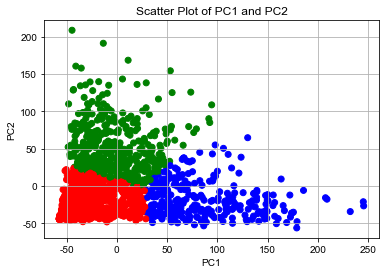

In [43]:
# 提取主成分得分和聚类类别
pc1_scores = result['PC1']
pc2_scores = result['PC2']
labels = result['cluster']

# 设置颜色映射
color_map = {0: 'red', 1: 'blue', 2: 'green'}  # 根据聚类类别定义颜色

# 绘制散点图
plt.grid()
plt.scatter(pc1_scores, pc2_scores, c=labels.map(color_map))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of PC1 and PC2')
plt.show()

从散点图来看，可以看到PC1和PC2都比较小的属于类0，PC1较大、PC2较小的属于类1，PC2较大、PC1较小的属于类2

从result中具体的例子来看，cluster这个字段取值为$\{0, 1, 2\}$，将球员分到了不同的3个类中，从结果来看，1号球员和6号、7号球员都在类1里面，他们的PC1都是比较大的正数，而0号球员、3号球员、4号球员都属于类0，他们的PC1和PC2都是负数，可以看出两个类存在明显不同